In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from keras.applications import DenseNet201

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Set the data path and categories
data_path = '/kaggle/input/koa-1500/MedicalExpert-I'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 256
data = []
label = []

# Load the images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            resized = cv2.resize(img, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

data = np.array(data) / 255.0
label = np.array(label)
new_label = np_utils.to_categorical(label)

# Split the data into train, test, and validation sets
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

# Define the data generators
datagen_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(x_train, y_train, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)

In [4]:
# Define the model architecture
model = Sequential()

# DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

# Additional Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               983552    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                      

In [5]:
# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [6]:
# Train the model
history = model.fit(train_generator,
                    epochs=60,
                    validation_data=val_generator,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/60
37/37 [==============================] - ETA: 0s - loss: 2.0295 - accuracy: 0.2719
Epoch 1: val_accuracy improved from -inf to 0.28485, saving model to /kaggle/working/model.h5
37/37 [==============================] - 50s 760ms/step - loss: 2.0295 - accuracy: 0.2719 - val_loss: 1.5592 - val_accuracy: 0.2848
Epoch 2/60
37/37 [==============================] - ETA: 0s - loss: 1.8372 - accuracy: 0.2779
Epoch 2: val_accuracy improved from 0.28485 to 0.34545, saving model to /kaggle/working/model.h5
37/37 [==============================] - 22s 581ms/step - loss: 1.8372 - accuracy: 0.2779 - val_loss: 1.4731 - val_accuracy: 0.3455
Epoch 3/60
36/37 [============================>.] - ETA: 0s - loss: 1.7279 - accuracy: 0.2726
Epoch 3: val_accuracy did not improve from 0.34545
37/37 [==============================] - 20s 526ms/step - loss: 1.7267 - accuracy: 0.2719 - val_loss: 1.4706 - val_accuracy: 0.3273
Epoch 4/60
37/37 [==============================] - ETA: 0s - loss: 1.6897 - acc

In [7]:
# Load the best weights
model.load_weights('/kaggle/working/model.h5')

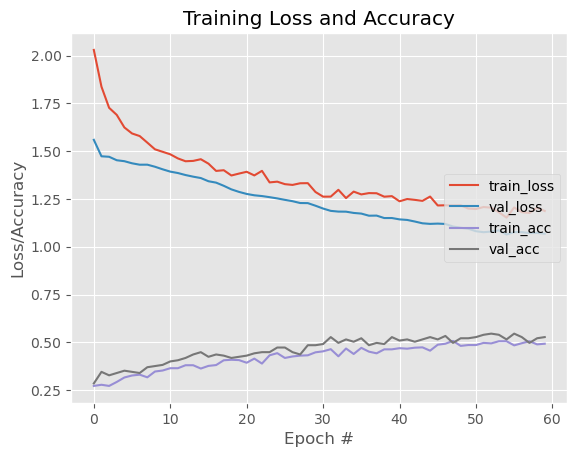

In [8]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("InceptionResNetV2_Model")

In [9]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

# Get the predictions for the test set
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the classification report
report = classification_report(np.argmax(y_test, axis=1), predicted_labels)
print(report)

Test loss: 1.0656006336212158
Test accuracy: 0.5454545617103577
11/11 [==============================] - 6s 184ms/step
              precision    recall  f1-score   support

           0       0.60      0.35      0.44       105
           1       0.72      0.52      0.60        50
           2       0.41      0.84      0.55        32
           3       0.50      0.15      0.23        48
           4       0.55      0.87      0.67        95

    accuracy                           0.55       330
   macro avg       0.55      0.55      0.50       330
weighted avg       0.57      0.55      0.51       330



<Figure size 640x480 with 0 Axes>

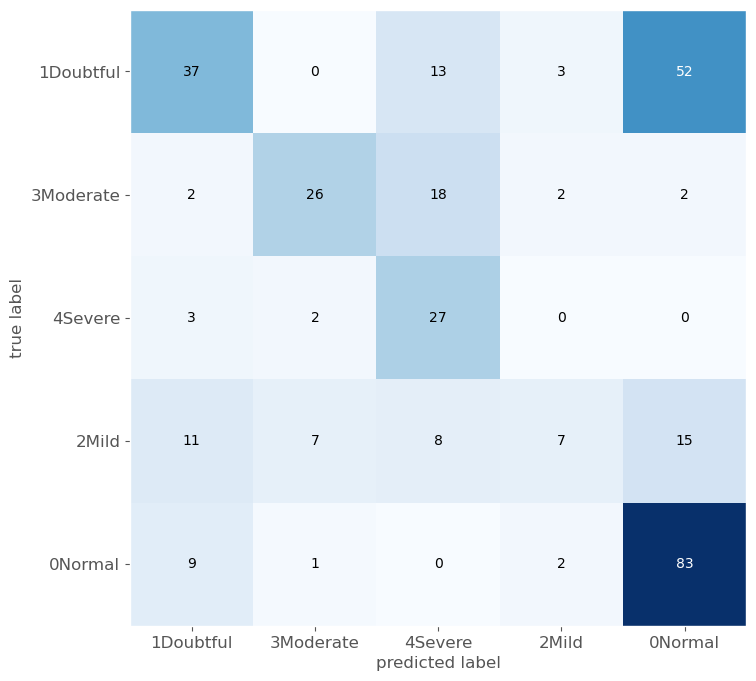

In [10]:
# Plot the confusion matrix
test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=12)
plt.yticks(range(len(categories)), categories, fontsize=12)
plt.show()

1/1 [==============================] - 2s 2s/step
A.I predicts: 2Mild
Correct prediction for label 1 is 3Moderate


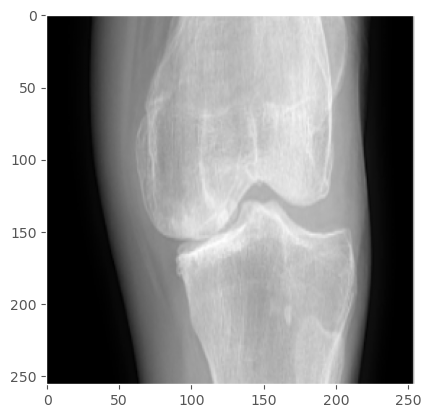

In [11]:
# Select a single image from the test set for prediction
X = 32
img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = np.expand_dims(img_single, 0)

# Make prediction on the single image
predictions_single = model.predict(img_single)
print('A.I predicts:', categories[np.argmax(predictions_single)])
print("Correct prediction for label", np.argmax(y_test[X]), 'is', categories[np.argmax(y_test[X])])

# Display the single image
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()
